In [1]:
#Import dependencies
import pydicom
from pydicom import dcmread
import pandas as pd
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import masked_array
import math
from scipy import misc,ndimage
from skimage import measure, morphology
from sklearn.cluster import KMeans
from skimage.draw import ellipse
from skimage.draw import ellipse_perimeter
from skimage.measure import label, regionprops, regionprops_table
from scipy.signal import find_peaks
import plotly.express as px

C:\Users\gmich\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#Get a list of the files in the current directory
directory = os.getcwd()
files = os.listdir(directory)

In [3]:
#Fiter the list of files be searching for unwanted strings or extensions (name of notebook, checkpoints, etc.)

# img_files = list(filter(lambda k: '.dcm' in k, files))
img_files = list(filter(lambda k: 'DICOM' not in k, files))
img_files = list(filter(lambda k: '.ipynb' not in k, img_files))

In [4]:
#Creating a list of the files and checking th tags for FOV, image type, and number of pixels

image_files = []
for file in img_files:
    ds = pydicom.read_file(file)
    try:
        print(ds[0x00181100].value)
        print(ds[0x00080008].value[2])
        print(ds.Rows)
        print(ds.Columns)
    except:
        print(f'There is no recon FOV tag for {file}')   
#     if ds.Rows == 512 and ds.Columns == 512 and ds[0x00080008].value[2] == 'AXIAL' and ds[0x00181100].value >= 250:
    if ds[0x00080008].value[2] == 'AXIAL' and ds[0x00181100].value >= 250:
        image_files.append(file)

327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512
327.000000
AXIAL
512
512


In [5]:
#Get the DICOM tags for an given file
file_path = image_files[73]
medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.528.1.1001.100.4.3081.3649.101545784305.20120426213234551
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.528.1.1001.2.20040707.2
(0002, 0013) Implementation Version Name         SH: 'AMI_DICOM03_2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20120316'
(0008, 0013) Instance Creation Time              TM: '180002'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP

In [6]:
medical_image['SliceLocation']

(0020, 1041) Slice Location                      DS: '-198.75'

In [7]:
#Get pixel data from DICOM file
image = medical_image.pixel_array
print(image.shape)

(512, 512)


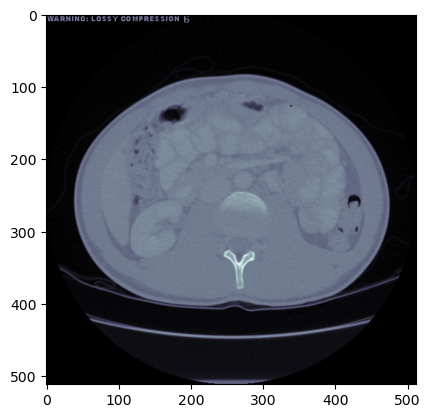

In [8]:
#Plot image
plt.imshow(image, cmap=plt.cm.bone)

In [9]:
"""This cell will iterate through the file list and populate a dataframe with the DICOM tags,
generate the x-ray tube and water equivalent diameter (WED) data, and also segment the images to remove the
patient table"""

tube_current = []
seg_images = []
masks = []
masked_images = []
mean_CT = []
WED = []
scans = []

model = KMeans(n_clusters=2, random_state=1, n_init='auto')

for i in image_files:
    ds = pydicom.read_file(i)
    tube_current.append(int(ds['XRayTubeCurrent'].value))
        
    scan_dict = {} #Populating dictionary with DICOM tags and values
    for element in ds:
        scan_dict[element.name] = str(element.value)

    del scan_dict['Pixel Data']
    del scan_dict['Image Type']
    #del scan_dict['Data Collection Center (Patient)']
#     del scan_dict['Reconstruction Target Center (Patient)']
    del scan_dict['Image Position (Patient)']
    del scan_dict['Image Orientation (Patient)']
    del scan_dict['Pixel Spacing']
    #del scan_dict['Referenced Raw Data Sequence']
    
    pixels = ds.pixel_array
    rescaled = pydicom.pixel_data_handlers.apply_rescale(pixels,ds)

    rescale_flat = rescaled.ravel()
    
    rescale_df = pd.DataFrame(
        {'CT_number': rescale_flat
        })
    
    model.fit(rescale_df)
    mask = model.predict(rescale_df)
    
    img_no = ds['InstanceNumber'].value
    
#     print(f"For image {img_no}:")
#     print(model.cluster_centers_)
    
    if model.cluster_centers_[0] > model.cluster_centers_[1]:
        mask_array=np.asarray(1-mask)
    else:
        mask_array=np.asarray(mask)  
            
    reshaped_mask = mask_array.reshape(pixels.shape[0], pixels.shape[1])
    reshaped_mask = ndimage.binary_fill_holes(reshaped_mask)
    reshaped_mask = morphology.remove_small_objects(reshaped_mask, 5000) #Removes the table
    reshaped_mask = reshaped_mask.astype(int)
    
    masked_image = reshaped_mask * rescaled
    
    masks.append(reshaped_mask)
    masked_images.append(masked_image)
    
    mask_flat = reshaped_mask.ravel()
    
    seg_image = np.zeros(len(rescale_flat))
    
    for i in range(len(mask_flat)):
        if mask_flat[i] == 0:
            seg_image[i] = -1000
        else:
            seg_image[i] = rescale_flat[i]
            
    seg_image = seg_image.reshape(512,512)
            
    seg_images.append(seg_image)
    
    n_pixels = reshaped_mask.sum()
    mean = masked_image.sum()/n_pixels
    mean_CT.append(mean)
    
    area_pixel = (ds['PixelSpacing'][0]/10)*(ds['PixelSpacing'][1]/10)
    area = area_pixel*n_pixels
    water_equiv = 2*math.sqrt((area/math.pi)*(mean/1000 + 1))
    WED.append(water_equiv)
    
    scan_dict['WED'] = water_equiv
    scans.append(scan_dict)

In [10]:
#Setting the index to the Instance Number
scan_df = pd.DataFrame(data=scans)
scan_df.set_index('Instance Number', inplace=True)

In [11]:
scan_df.head()

Specific Character Set Instance Creation Date  \
Instance Number                                                 
1                           ISO_IR 100               20120316   
2                           ISO_IR 100               20120316   
3                           ISO_IR 100               20120316   
4                           ISO_IR 100               20120316   
5                           ISO_IR 100               20120316   

                Instance Creation Time              SOP Class UID  \
Instance Number                                                     
1                               175947  1.2.840.10008.5.1.4.1.1.2   
2                               175948  1.2.840.10008.5.1.4.1.1.2   
3                               175948  1.2.840.10008.5.1.4.1.1.2   
4                               175948  1.2.840.10008.5.1.4.1.1.2   
5                               175948  1.2.840.10008.5.1.4.1.1.2   

                                                  SOP Instance UID Study Date  \
Instance Number                                                                 
1                1.2.528.1.1001.100.4.3081.3649.101545784305.20...              
2                1.2.528.1.1001.100.4.3081.3649.101545784305.20...              
3                1.2.528.1.1001.100.4.3081.3649.101545784305.20...              
4                1.2.528.1.1001.100.4.3081.3649.101545784305.20...              
5                1.2.528.1.1001.100.4.3081.3649.101545784305.20...              

                Series Date Acquisition Date Content Date Study Time  ...  \
Instance Number                                                       ...   
1                  20120316         20120316     20120316     175527  ...   
2                  20120316         20120316     20120316     175527  ...   
3                  20120316         20120316     20120316     175527  ...   
4                  20120316         20120316     20120316     175527  ...   
5                  20120316         20120316     20120316     175527  ...   

                [IterativeReconLevel] [reconFlipRotateAnno]  \
Instance Number                                               
1                                  30                         
2                                  30                         
3                                  30                         
4                                  30                         
5                                  30                         

                [highResolutionFlag] [RespiratoryFlag] [NEW/SEEN Status]  \
Instance Number                                                            
1                                  0                 0               NEW   
2                                  0                 0               NEW   
3                                  0                 0               NEW   
4                                  0                 0               NEW   
5                                  0                 0               NEW   

                           [Receive Origin] [Receive Date] [Receive Time]  \
Instance Number                                                             
1                smhmc-amps.ds.ad.ssmhc.com       20120426         150458   
2                smhmc-amps.ds.ad.ssmhc.com       20120426         150458   
3                smhmc-amps.ds.ad.ssmhc.com       20120426         150458   
4                smhmc-amps.ds.ad.ssmhc.com       20120426         150458   
5                smhmc-amps.ds.ad.ssmhc.com       20120426         150458   

                [Receive Origin Description]        WED  
Instance Number                                          
1                                    AMIPROD  22.840496  
2                                    AMIPROD  22.848097  
3                                    AMIPROD  22.787263  
4                                    AMIPROD  22.668946  
5                                    AMIPROD  22.682381  

[5 rows x 210 columns]

In [12]:
scan_df[["Slice Location", "X-Ray Tube Current"]] = scan_df[["Slice Location", "X-Ray Tube Current"]].apply(pd.to_numeric)
z_locations = scan_df['Slice Location']

In [13]:
scan_df = scan_df.sort_values('Slice Location')

<Axes: xlabel='Slice Location'>

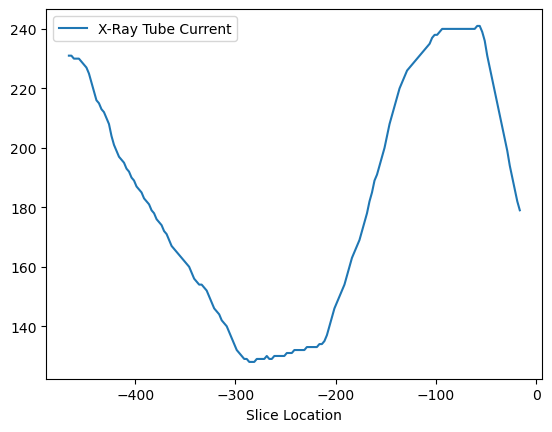

In [14]:
scan_df.plot(kind='line',
        x='Slice Location',
        y='X-Ray Tube Current')

In [15]:
slice_locations = scan_df['Slice Location']
slice_locations[50]

-403.75

<Axes: xlabel='Slice Location'>

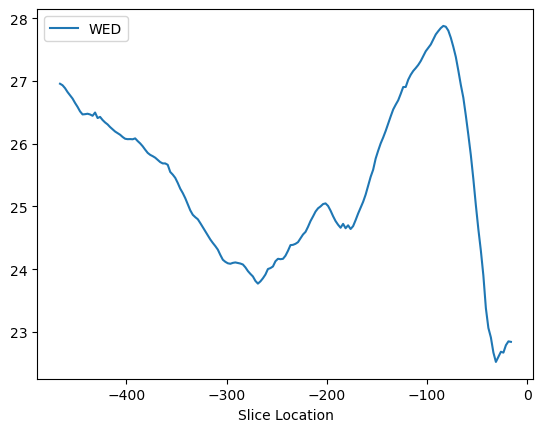

In [16]:
scan_df.plot(kind='line',
        x='Slice Location',
        y='WED')

Text(0, 0.5, 'WED')

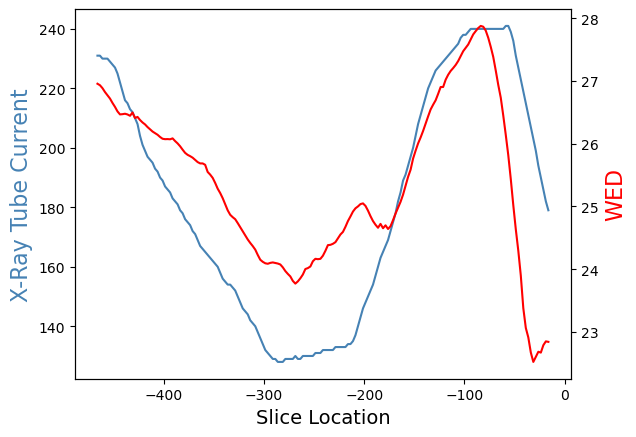

In [17]:
#Creating a plot of the tube current and WED

col1 = 'steelblue'
col2 = 'red'

fig,ax = plt.subplots()

#add first line to plot
ax.plot(scan_df['Slice Location'], scan_df['X-Ray Tube Current'], color=col1)

#add x-axis label
ax.set_xlabel('Slice Location', fontsize=14)

#add y-axis label
ax.set_ylabel('X-Ray Tube Current', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(scan_df['Slice Location'], scan_df['WED'], color=col2)

#add second y-axis label
ax2.set_ylabel('WED', color=col2, fontsize=16)

In [18]:
def measure_ROI(img_no):
    
    """Call this function to manually measure the noise by entering the coordinates of a circular ROI
    and its diamter in pixels"""
    
    print('Enter the location and size of the region of interest:')
    x_coord = input('X: ')
    y_coord = input('Y: ')
    size = input('Pixels in diameter: ')
    
    rr, cc = ellipse(int(y_coord), int(x_coord), int(size), int(size))
    ro, co = ellipse_perimeter(int(y_coord), int(x_coord), int(size), int(size))
    
    roi = seg_images[img_no][rr,cc]
    
    noise = np.std(roi)
    HU = np.mean(roi)
    
    noise_img = np.copy(seg_images[img_no])
    
    noise_img[ro, co] = 1000
    
    plt.imshow(noise_img, cmap=plt.cm.bone)
    
    print(f'Noise for ROI at {x_coord}, {y_coord} is {noise}')
    print(f'Mean CT number for ROI at {x_coord}, {y_coord} is {HU}')
    
    return noise, HU

In [19]:
def measure_noise(img_no, ROI_size, tissue_type):
    
    """Measures the image noise after categorizing tissue types based on thresholding. The user can
    specify in which tissue type the noise should be measured."""
    
    ct_numbers = seg_images[img_no].ravel()

    cat_image = np.zeros(len(ct_numbers))
    
    for i in range(len(ct_numbers)):
        if ct_numbers[i] < -300:
            cat_image[i] = 0
        elif ct_numbers[i] < -50:
            cat_image[i] = 1
        elif ct_numbers[i] < 100:
            cat_image[i] = 2
        else:
            cat_image[i] = 3
    
    cat_image = cat_image.reshape(512,512)
    
    if tissue_type == 'fat':
        soft_tissue_mask = np.where(cat_image == 1, 1, 0)
    else:
        soft_tissue_mask = np.where(cat_image == 2, 1, 0)
        
    noise = []
    noise_map = np.copy(soft_tissue_mask)
    for i in range(soft_tissue_mask.shape[0]):
        for j in range(soft_tissue_mask.shape[1]):
            if soft_tissue_mask[i][j] == 1:
                rr, cc = ellipse(int(i), int(j), int(ROI_size), int(ROI_size))
                try:
                    roi = seg_images[img_no][rr,cc]
                    SD = np.std(roi)
                    noise_map[i,j] = SD
                    noise.append(SD)
                except:
                    pass
    
    plt.imshow(soft_tissue_mask, cmap=plt.cm.bone)
                
    return noise, noise_map

In [20]:
def measure_noise_clusters(img_no, ROI_size):
    
    """Measures the global image noise after segmenting image based on k-means clusters"""
    
    ct_numbers = seg_images[img_no].ravel()
    
    image = pd.DataFrame()
    image['CT_Number'] = ct_numbers
    
    model = KMeans(n_clusters=4, random_state=1, n_init='auto')
    model.fit(image[['CT_Number']])
    image['Tissue'] = model.predict(image[['CT_Number']])
    
    tissue_mask = np.asarray(image['Tissue']).reshape(512,512) #Create a mask for tissue types
    
    # Getting the cluster location of the soft tissue
    st_loc = int() 
    sorted_clusters = sorted(model.cluster_centers_)
    
    for i in range(len(model.cluster_centers_)):
        
        if model.cluster_centers_[i] == sorted_clusters[2][0]: #This indicates we would like to use cluster 2 for our noise calculation
            st_loc = i

#     for i in range(len(model.cluster_centers_)):
#         if model.cluster_centers_[i] > -80 and model.cluster_centers_[i] < 100:
#             st_loc = i
#             break
            
    print(f'The soft tissue pixels are located in cluster {st_loc} with a mean value of {model.cluster_centers_[st_loc][0]} HU.')
#     if tissue_type == "Soft Tissue"
    
    image["soft_tissue"] = np.where(image['Tissue'] == st_loc, 1, 0)
    soft_tissue_mask = np.array(image['soft_tissue']).reshape(512,512)
      
    noise = []

    noise_map = np.copy(soft_tissue_mask)
    for i in range(soft_tissue_mask.shape[0]):
        for j in range(soft_tissue_mask.shape[1]):
            if soft_tissue_mask[i][j] == 1:
                rr, cc = ellipse(int(i), int(j), int(ROI_size), int(ROI_size))
                try:
                    roi = seg_images[img_no][rr,cc]
                    SD = np.std(roi)
                    noise_map[i,j] = SD
                    noise.append(SD)
                except:
                    pass
    image_dict = dict(enumerate(model.cluster_centers_.flatten(), 0))
    print(f'Mean CT numbers for clusters: {image_dict}')
    plt.imshow(soft_tissue_mask, cmap=plt.cm.bone)
                
    return noise, noise_map

In [21]:
def find_img_number(arr):
    
    """This function will find the slice number from the user entered z-position"""
    
    target = float(input('Enter approximate slice location: '))
    return np.argmin(np.abs(arr - target))

In [22]:
def get_noise_curve(z_locations):
    
    """This will accept a user input of the z-locations in which the user would like to measure the 
    global noise."""
    
    img_nums = []
    z_locs = []
    img_1 = find_img_number(z_locations)
    img_nums.append(img_1)
    z_locs.append(z_locations[img_1])
    
    img_input = True
    
    while img_input:
        keep_adding = input('Add another image (y/n)?')
        if  keep_adding == 'y':
            next_img = find_img_number(z_locations)
            img_nums.append(next_img)
            z_locs.append(z_locations[next_img])
        else:
            img_input = False
            
    return img_nums, z_locs

In [23]:
img_no = find_img_number(z_locations)
img_no

Enter approximate slice location: -200


73

Enter approximate slice location: -100
Add another image (y/n)?y
Enter approximate slice location: -200
Add another image (y/n)?n
Noise peak at z = -98.75 cm is at 16.016620949918288 with 2686 counts
Noise value with the maximum counts is 16.016620949918288 with 2686 counts


Noise peak at z = -198.75 cm is at 18.407428663314505 with 3850 counts
Noise value with the maximum counts is 18.407428663314505 with 3850 counts




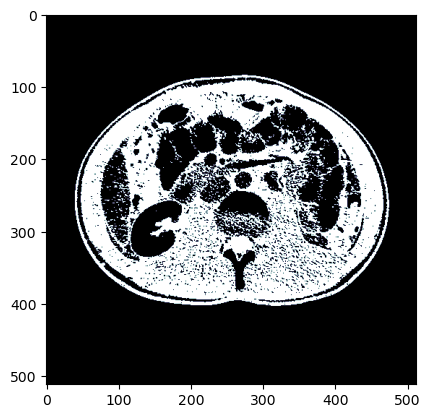

In [25]:
#You can loop through the user defined noise locations to get multiple global noise estimates

im, z = get_noise_curve(z_locations)
ROI_size = 10
noise_curve = []

for i in range(len(im)):
    img_noise, img = measure_noise(im[i], ROI_size, 'soft tissue') #Measure global noise
#     plt.imshow(img)
#     plt.colorbar()
    hist = np.histogram(img_noise, bins=300, range=None, density=None, weights=None)
    peaks = find_peaks(hist[0], height=0)
    print(f'Noise peak at z = {z[i]} cm is at {hist[1][peaks[0][0]]} with {hist[0][peaks[0][0]]} counts')
    print(f'Noise value with the maximum counts is {hist[1][hist[0].argmax()]} with {hist[0][hist[0].argmax()]} counts')
    print('\n')
    noise_curve.append(hist[1][hist[0].argmax()])

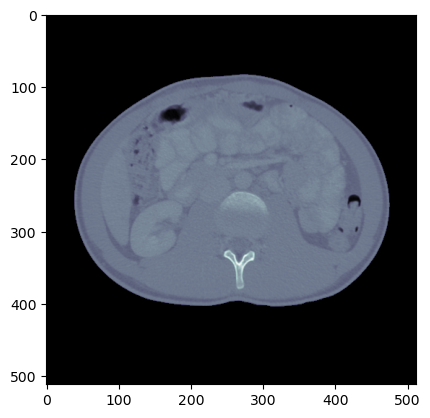

In [26]:
#Plotting an example image

plt.imshow(seg_images[img_no], cmap=plt.cm.bone)

Enter the location and size of the region of interest:
X: 200
Y: 350
Pixels in diameter: 20
Noise for ROI at 200, 350 is 16.453262962069207
Mean CT number for ROI at 200, 350 is 81.36867469879518


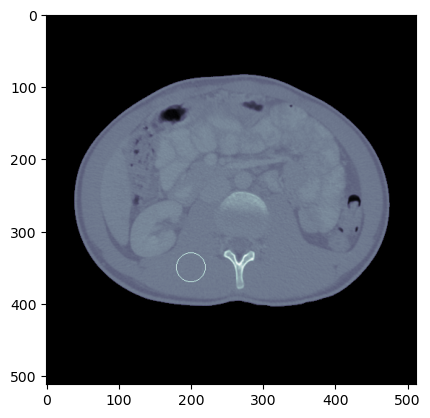

In [27]:
noise, HU = measure_ROI(img_no) #Measure noise with ROI

The soft tissue pixels are located in cluster 3 with a mean value of 21.315427790170588 HU.
Mean CT numbers for clusters: {0: 129.4725507598123, 1: -999.5497314614784, 2: -329.610807860262, 3: 21.315427790170588}


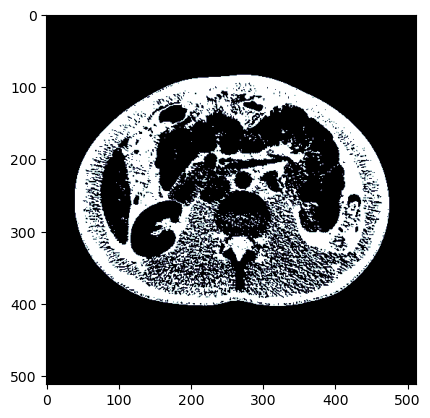

In [28]:
#Use the k-means clustering algorithm to measure global noise

ROI_size = 10
img_noise_clust, img_clust = measure_noise_clusters(img_no, ROI_size) #Measure global noise

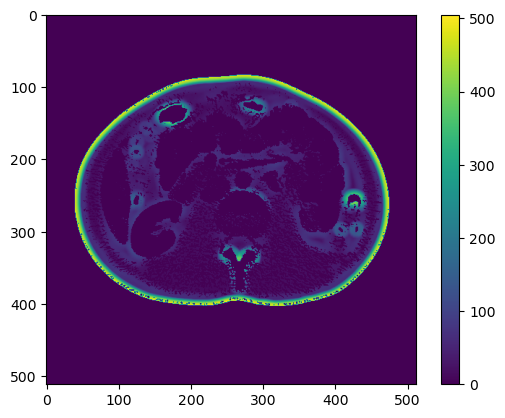

In [29]:
plt.imshow(img_clust)
plt.colorbar()

In [38]:
fig = px.histogram(img_noise_clust, nbins=300)  # Adjust the number of bins as desired
fig.show()

In [39]:
hist = np.histogram(img_noise_clust, bins=300, range=None, density=None, weights=None)
peaks = find_peaks(hist[0], height=0)
f'Noise peak is at {hist[1][peaks[0][0]]} with {hist[0][peaks[0][0]]} counts'

'Noise peak is at 16.827836480747372 with 1969 counts'

In [40]:
f'Noise value with the maximum counts is {hist[1][hist[0].argmax()]} with {hist[0][hist[0].argmax()]} counts'

'Noise value with the maximum counts is 16.827836480747372 with 1969 counts'

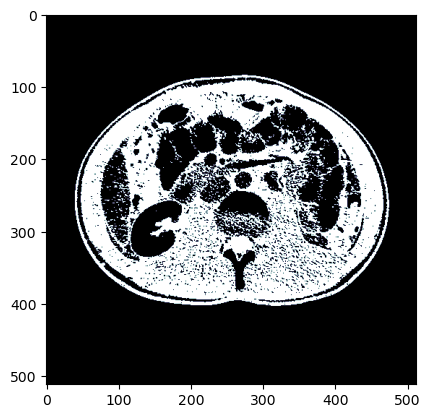

In [32]:
#Use the thresholding algorithm to measure global noise
img_noise, img = measure_noise(img_no, ROI_size, 'soft tissue')

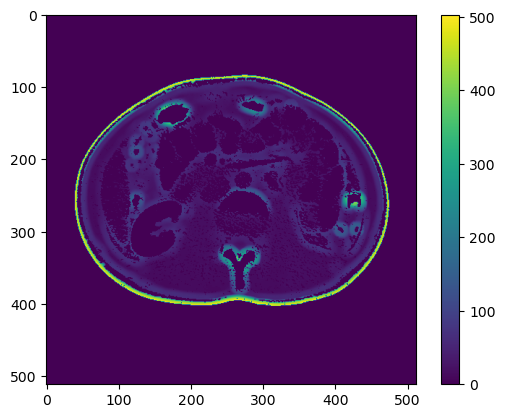

In [33]:
plt.imshow(img)
plt.colorbar()

In [34]:
fig = px.histogram(img_noise, nbins=300)  # Adjust the number of bins as desired
fig.show()

In [36]:
hist = np.histogram(img_noise, bins=300, range=None, density=None, weights=None)
peaks = find_peaks(hist[0], height=0)
f'Noise peak is at {hist[1][peaks[0][0]]} with {hist[0][peaks[0][0]]} counts'

'Noise peak is at 18.407428663314505 with 3850 counts'

In [37]:
f'Noise value with the maximum counts is {hist[1][hist[0].argmax()]} with {hist[0][hist[0].argmax()]} counts'

'Noise value with the maximum counts is 18.407428663314505 with 3850 counts'